In [7]:
import matplotlib.pyplot as plt
import numpy as np 
from astropy.io  import ascii 
from astropy.table import Table
from astropy import  units as u 
import glob 
import scipy as sp 

from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity 

In [8]:

files = glob.glob('./SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_*')

['./SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_MF1.txt', './SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_MF2.txt', './SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_LF2.txt', './SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_LF1.txt', './SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_UHF2.txt', './SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_UHF1.txt']


Text(0.5, 1.0, 'SO bandpasses ')

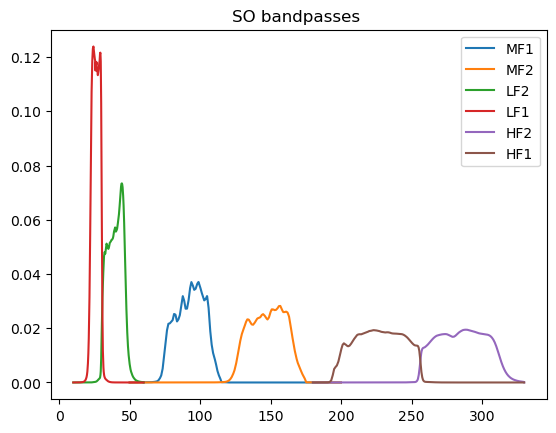

In [9]:
print(files) 
for f in files: 
    label = ((f.split(".")[1][-3:] ))
    arr =np.loadtxt(f,skiprows=1)
    plt.plot(arr[:,0], arr[:,1]/np.trapz(arr[:,1],arr[:,0]), label=label ) 
bnu = arr[:,1] 
nu = arr[:,0]    
plt.legend() 
plt.title('SO bandpasses ')


## Simulation of bandpasses 


1.  normalize the bpass , so that $ \int b_{\nu} d\nu =1 $ 
2. interpolate the cumulative function $C (\nu) = \int _{\nu_{min} } ^{\nu} d \nu b_{\nu} $
3. bootstrap resample with probability $b_{\nu}$ frequencies with the measured bpass 
4. use Gaussian Kernel Density Estimates from the bootstrap frequencies to sample a new band, (after Gridsearched for the optimal kernel width) 
5. generate $N_{waf}$  resampled bpasses  for each LAT wafer  and for each freq. band   


### Definition of Band centroid and bandwidth 

assuming that 
$$ \int b({\nu}) d\nu =1 
$$

$$ \bar{\nu} =\int \nu b({\nu}) d\nu  
$$
and 
$$ \Delta{\nu}^2 =\int (\nu -\bar{\nu})^2 b({\nu}) d\nu  
$$

In [10]:


def bandpass_distribution_function(bnu , nu ): 
    A=np.trapz( bnu ,nu)
    #normalize it to make it a PDF 
    if A !=1 : bnu/=A  
        
    #Interpolate the band 
    b = sp.interpolate.interp1d(x=nu, y=bnu ) 
    #estimate the CDF 
    Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ]) 
    #interpolate the inverse CDF
    Binterp = sp.interpolate.interp1d(Pnu ,nu[:-1] + np.diff(nu), bounds_error=False, fill_value="extrapolate")  
    return Binterp


def search_optimal_kernel_bwidth (x  ):

    bandwidths =  np.logspace(np.log(0.7), np.log(4) , 16) 
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=LeaveOneOut() )  
    grid.fit(x[:, None]);
    return  grid.best_params_['bandwidth'] 
    
def bandpass_kresampling(h, nu_i ,range , nresample=54 ): 
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=h, kernel='gaussian')
    kde.fit(nu_i[:, None])
    nud = np.linspace(*range , nresample ) 
    # score_samples returns the log of the probability density
    resampled_bpass  = np.exp(kde.score_samples(nud[:, None]) ) 
    
    return nud , resampled_bpass

def bandpass_resampling(Binterp, nu, bstrap_size= 1000, nresample=54 ): 
    X =  np.random.uniform(size=bstrap_size)
    bins_nu=np.linspace(nu.min()*1.1, nu.max()*1.2,nresample)
    
    h, xb =np.histogram(Binterp( X ), density=True ,bins= bins_nu   )
    
    nu_b  = xb[:-1] + np.diff(xb)
    resampled_bpass =abs(sp.interpolate.interp1d(nu_b, h, kind='slinear', bounds_error=False, fill_value=0. )(nu))
    return nu, resampled_bpass/np.trapz(resampled_bpass,nu )



In [11]:
norm = np.trapz(bnu,nu )

bnu /=norm 
mom1 = lambda x ,f  : np.trapz(f*x,x )
mom2 = lambda x,f:  np.trapz (f *(x - mom1(x,f))**2 ,x )
interpolated_cdf  = bandpass_distribution_function(bnu = bnu, nu =nu  )
centroid =[] 
width=[] 
h =0. 
bstrap_size= np.int_(np.floor(nu.size    *np.log(nu.size)**2) ) # use N (log N^2 ) 
print(bstrap_size)

np.random.seed(1929) 
 
for i in range( 1 ): 

    X =  np.random.uniform(size=bstrap_size)
    nuresampled = interpolated_cdf( X )
    if h==0: 
        h = search_optimal_kernel_bwidth(nuresampled ) 
        print(h  ) 
    fr, resampled_band = bandpass_kresampling(h , nuresampled ,range = [nu.min(), nu.max() ], nresample=bstrap_size   ) 
    
    fbar = mom1(fr ,resampled_band  )  
    variance = mom2(fr ,resampled_band  )  
    centroid .append( fbar  )
    width .append( np.sqrt(variance ) )
    plt.figure()
    plt.plot(fr, resampled_band ,alpha=1, color= 'C1', label='resampled ')
    plt.plot(nu, bnu ,'--', color='black' ,alpha=1, label='nominal ' )
nubar= np.trapz(nu *bnu , nu )
plt.axvline(nubar , ymax=1,linestyle='--', color='black' ,alpha=1 ) 
plt.xlabel('GHz')
plt.legend() 
plt.figure()
plt.subplot(121)
plt.title('Centroid' ) 
plt.hist(centroid ) 
plt.xlabel('GHz' ) 
plt.axvline(np.trapz(nu *bnu,nu )  , ymax=1,linestyle='--', color='black' ,alpha=.5) 
#plt.hist(width  ) 
plt.subplot(122)
plt.title('Bandwidth' )
plt.hist(width  ) 
plt.axvline(np.sqrt((np.trapz((nu  - nubar)**2*bnu , nu )) )  , ymax=1,linestyle='--', color='black' ,alpha=.5) 
plt.xlabel('GHz' ) 


/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


80224


: 

/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


MF1	 Band centroid 	 Bandwidth
	 92.97839957972313	9.808360281467987
Resampling with 9759
	 0.0020027643604445533	0.010130472096418819
	 0.00094851506893745	0.012239392406789396
	 0.0005015434587987144	0.012104787139886497
	 0.0030240479427234845	0.013529085916649253
	 0.0019834074907322252	8.428645558944403e-06
	 0.00030046136106753885	0.01042275633993639
	 0.0008931928671780387	0.007469299844711452
	 0.0011739896229128188	0.004350457066174096


/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


MF2	 Band centroid 	 Bandwidth
	 147.96174102674829	12.134645024284412
Resampling with 9759
	 0.0014599386495894873	0.004384180976571672
	 0.0008096592957738125	0.008052472597000149
	 0.0003745770537932902	0.007276191102940643
	 0.0023446489617897637	0.010477552585970384
	 0.0015913705530372635	0.0022699930980697447
	 0.00020470945774087035	0.006582046693525356
	 0.0007021532294959609	0.0054627524312882425
	 0.0009152105368265273	0.002367553272930367


/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


LF2	 Band centroid 	 Bandwidth
	 39.851501858156674	5.277381886118146
Resampling with 2120
	 0.002901196476466472	0.027200125505548733
	 0.00016580286165246427	0.021680197180197647
	 0.004343467627445863	0.00682841013028157
	 0.00330096435900451	0.033357057590228


/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


LF1	 Band centroid 	 Bandwidth
	 26.117508234330987	2.5977014305617097
Resampling with 2120
	 0.0020221641422799586	0.08400230268421272
	 0.0002817074232186467	0.08090382802774876
	 0.003105022467559504	0.061040461325567064
	 0.0027645027283040857	0.10708038142379794


/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


HF2	 Band centroid 	 Bandwidth
	 285.96487371772776	16.55183449627227
Resampling with 9759
	 0.0008343537210386831	0.0027106643507754935
	 0.0007815460686046993	0.004485646381475528
	 0.00012853012420377397	0.004799487933067059
	 0.001396587327869847	0.008966286826876058
	 0.0011645130659941882	0.004144194164181103
	 3.7466246869066744e-05	0.0044441220229620715


/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_91487/82734111.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ])


HF1	 Band centroid 	 Bandwidth
	 226.98580623582527	16.43944796057083
Resampling with 9759
	 0.0012750301889001836	0.0033326664736250677
	 0.0006339297277451195	0.006339092466739693
	 0.0003142521738410675	0.004989184104043476
	 0.0020709034026971107	0.008508337795702703
	 0.0014206806720504783	0.004843207947860639
	 0.00018569293638748263	0.005403019660178643


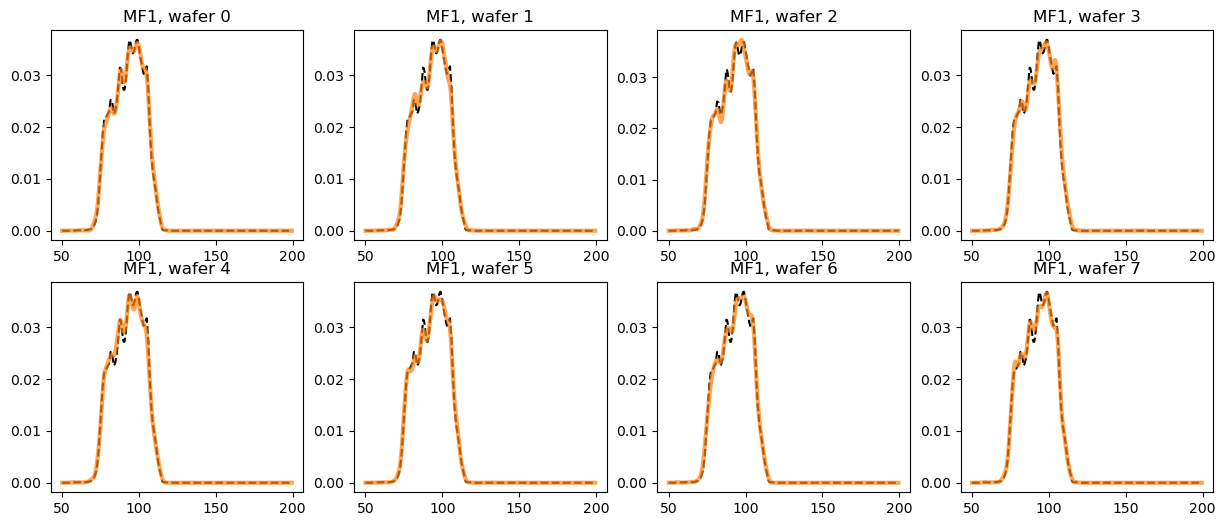

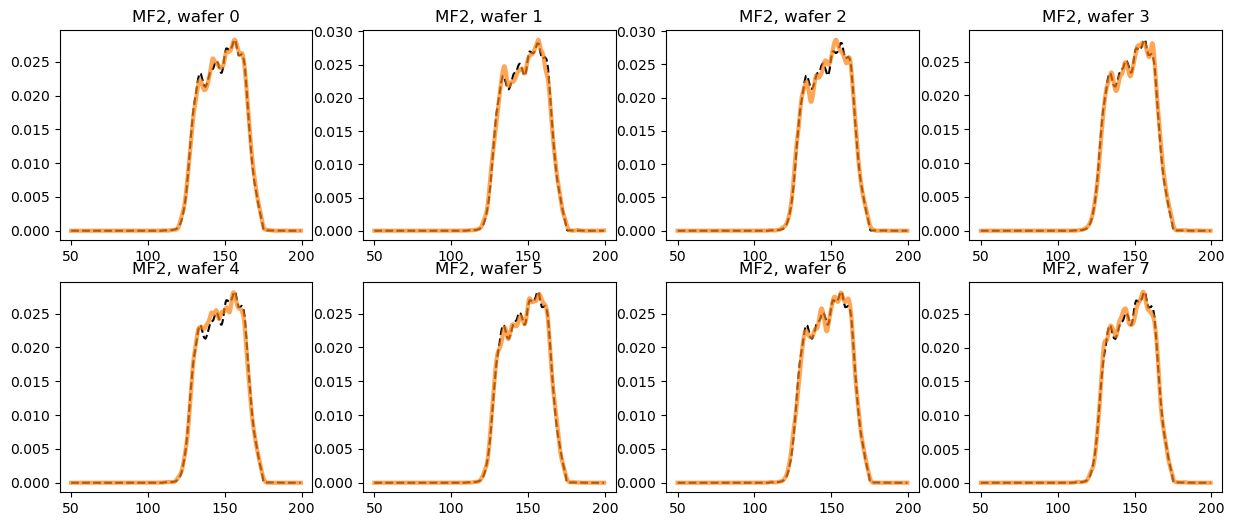

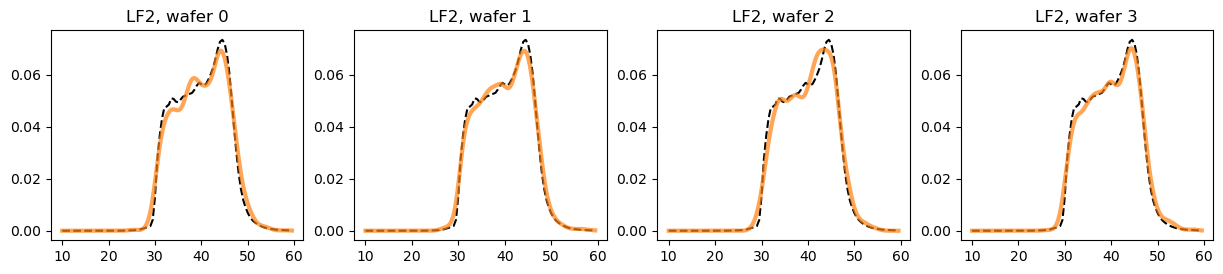

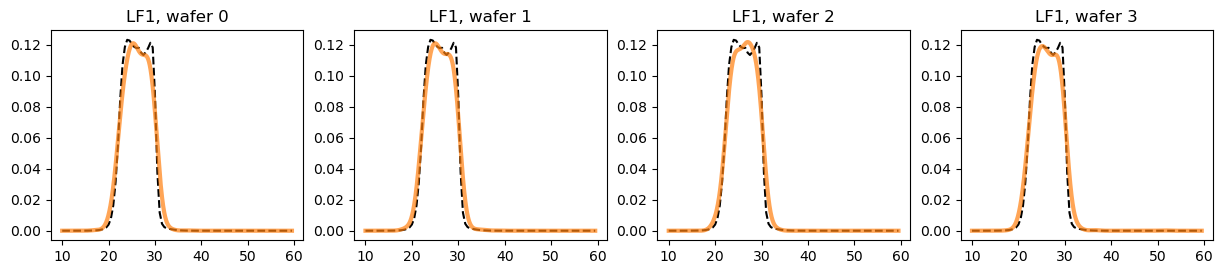

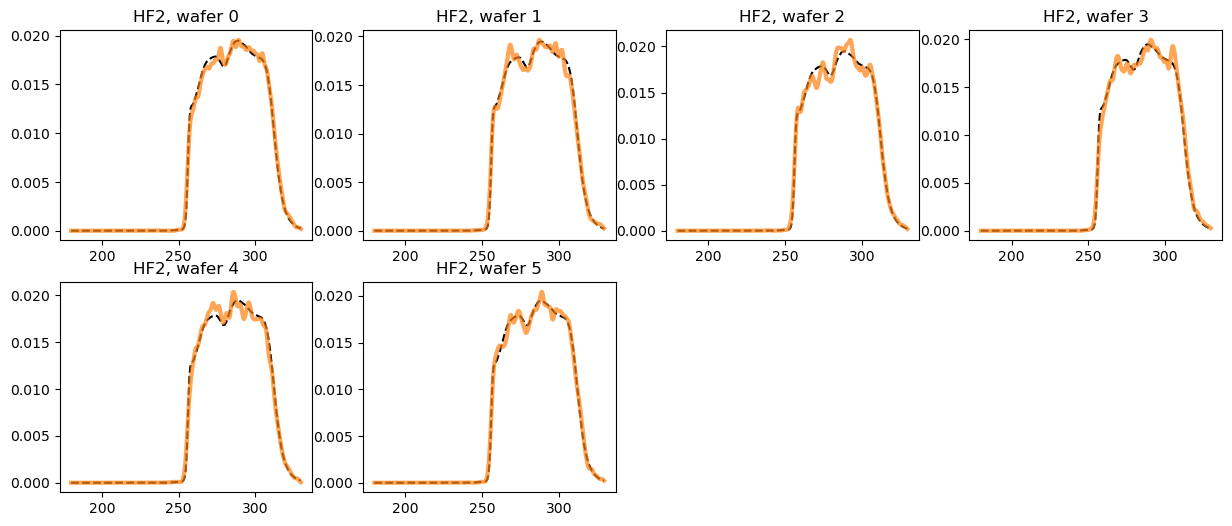

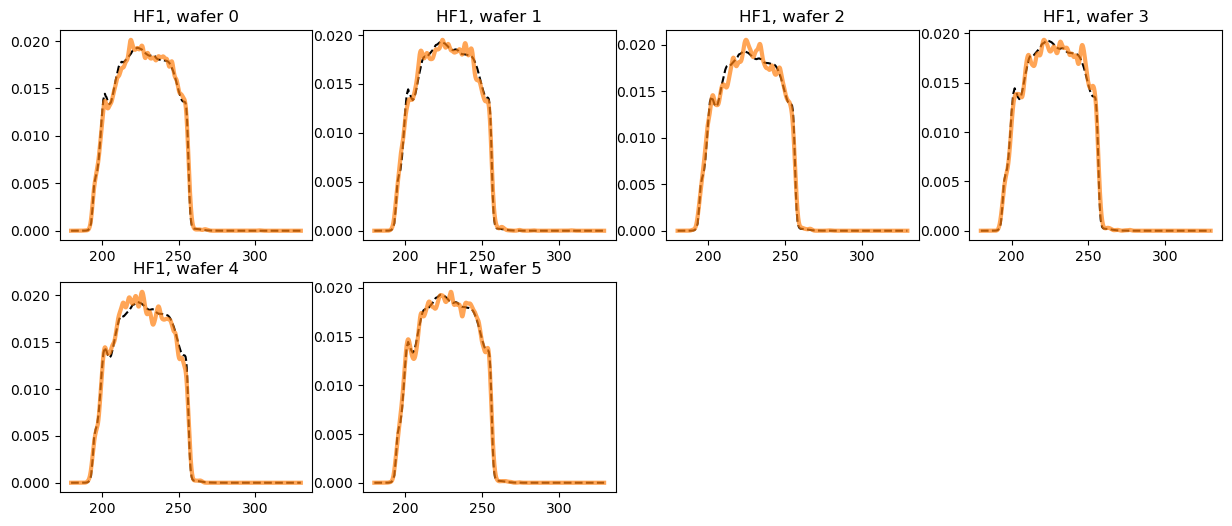

In [6]:

files = glob.glob('./SO_E2E_Passbands/LAT/Baseline/SO_LAT_E2E_Passband_V3r7_Baseline_*')
dic_nwaf = {"LF1":4, "MF1":8, "HF1":6,
           "LF2":4, "MF2":8, "HF2":6}    
for f in files: 
    idfreq  = ((f.split(".")[1][-3:] ))
    Nwafers=dic_nwaf[idfreq] 
    arr =np.loadtxt(f,skiprows=1)
    
    bnu = arr[::5,1] 
    nu = arr[::5,0]    
    bnu /=np.trapz(bnu,nu )
    norm = np.trapz(bnu,nu )
    interpolated_cdf  = bandpass_distribution_function(bnu = bnu, nu =nu  )
    
    bstrap_size= np.int_(np.floor(nu.size    *np.log(nu.size)**2) ) # use N (log N^2 ) 
    
    nubar= mom1(nu, bnu) 
    nuvar=  np.sqrt(mom2(nu, bnu) )
    print( f"{idfreq}\t Band centroid \t Bandwidth\n\t {nubar}\t{nuvar}" ) 
    plt.figure(figsize=(15,6) ) 
    np.random.seed(1929) 
    print(f"Resampling with {bstrap_size}")
    h =1. 
    data = Table()
    
    for i in range( Nwafers  ): 

        plt.subplot(241+i) 
        plt.plot(nu, bnu ,'--', color='black' ,alpha=1  )
        
        plt.title(f"{idfreq}, wafer {i}") 
        
        X =  np.random.uniform(size=bstrap_size)
        nuresampled = interpolated_cdf( X )
        
        if h==0: 
            h = search_optimal_kernel_bwidth(nuresampled ) 
            print(f"Optimal Gaussian kernel width {h}") 
        fr, resampled_band = bandpass_kresampling(h , nuresampled ,range = [nu.min(), nu.max() ], nresample=bstrap_size   ) 
        fbar = mom1(fr ,resampled_band  )  
        variance = np.sqrt(mom2(fr ,resampled_band  )  ) 
        print( f"\t {np.fabs(fbar/nubar -1)}\t{np.fabs(variance/nuvar -1 )  }" ) 

        plt.plot(fr, resampled_band,color="C1" , alpha=.7,lw=3,  label=r"$\bar{\nu}=$"+f"{fbar:.2f} GHz,"+r"$ \Delta \nu =$"+f"{variance:.2f} GHz")
        #plt.xlabel('GHz')
        #plt.legend() 
        data[f'bandpass_frequency'] = fr *u.GHz 
        data[f'bandpass_weights'] = resampled_band   
        data.write(f'resampled_bpasses_{idfreq}_w{i}.tbl', format='ascii.ipac', overwrite=True)  



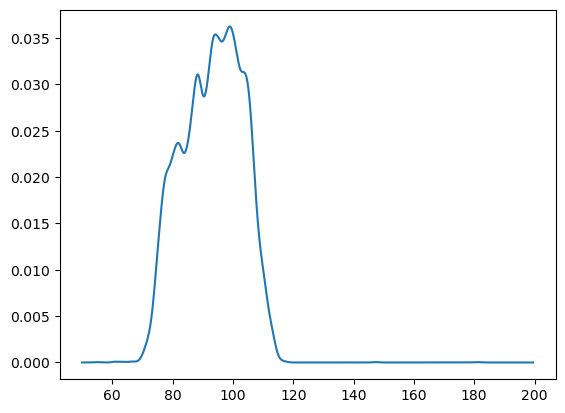

In [22]:
from astropy.table import QTable
QTable.read('resampled_bpasses_MF1_w0.tbl', format='ascii.ipac')

plt.plot(tab ["bandpass_frequency" ] ,tab ["bandpass_weights" ] ) 

In [23]:
tab.columns

<TableColumns names=('bandpass_frequency','bandpass_weights')>